Solve 

$$
\left( \partial^2_t - \partial^2_x  + m \right) \Psi(t,x) = 0.
$$

Using 

$$
\Psi(t,x) = \sum_n^{N-1} \hat{u}_n(t) \cos(n x)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scalar
import matplotlib.animation as animation

In [2]:
N = 121

x_range = (-3, 3)


basis = scalar.Basis1D(N, axis=x_range)

x = basis.r
index = np.arange(N)

D2 = basis.D2


def sigmoid(x):
    return 1 / (1 + np.exp(-x))
c = 1 + 0.5*sigmoid(100*(x-1))

In [3]:
def init_profile(x, sigma=0.2):
    return np.exp(-((x+1) ** 2)/(2*sigma*sigma) )/ (np.sqrt(2*np.pi)*sigma)

In [4]:
u0 = init_profile(x)
v0 = np.zeros_like(u0)

hu0 = basis.dct(u0)

u0_ = basis.idct(hu0)

In [5]:
# Rk4 algorithm
def rk4(u, v, dt, f, g):
    k1 = dt * f(u, v)
    l1 = dt * g(u, v)

    k2 = dt * f(u + 0.5 * k1, v + 0.5 * l1)
    l2 = dt * g(u + 0.5 * k1, v + 0.5 * l1)

    k3 = dt * f(u + 0.5 * k2, v + 0.5 * l2)
    l3 = dt * g(u + 0.5 * k2, v + 0.5 * l2)

    k4 = dt * f(u + k3, v + l3)
    l4 = dt * g(u + k3, v + l3)

    u_next = u + (k1 + 2*k2 + 2*k3 + k4) / 6
    v_next = v + (l1 + 2*l2 + 2*l3 + l4) / 6

    return u_next, v_next


def fu(u, v):

    return v

def fv(u, v):
    # Get uhat
    uhat = basis.dct(u)
    # Compute laplacian
    hu_xx = uhat @ D2
    u_xx = basis.idct(hu_xx)

    return c**2*u_xx



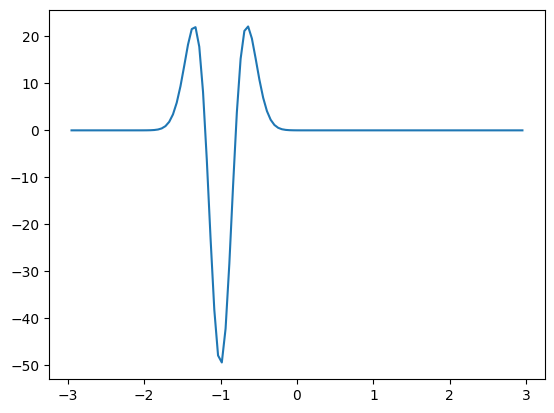

In [6]:
hu_xx = D2 @ hu0
u_xx = basis.idct(hu_xx)

plt.plot(x, u_xx, label='Laplacian')
plt.show()


In [7]:
# Principal loop

dt = 0.001
tmax = 10.
t = 0.
T = [t]
U = [u0]
HU = [hu0]
V = [v0]
u = u0
v = v0

U_FWI = []
U_data = []


for i in range(3001):
    u, v = rk4(u, v, dt, fu, fv)
    t += dt


    if i % 10 == 0:
        u_space = u[60]

        U_FWI.append(u_space)

    if i % 20 == 0:
        T.append(t)
        U.append(u)
        V.append(v)
        HU.append(basis.dct(u))
        
    if i == 3000:
        U_data.append(u)


U_data = np.array(U_data)
U = np.array(U)
V = np.array(V)

In [8]:
# Save the data as txt

#np.savetxt('scalar.txt', np.column_stack((T, U)), header='t u', comments='')
#np.savetxt('x.txt', x)
#np.savetxt('t.txt', T)
#np.savetxt('u.txt', U)

#np.savetxt('u_data.txt', U_data)
#np.savetxt('u_fwi.txt', np.array(U_FWI))

In [9]:
import torch

# Save as torch tensor

U = torch.tensor(U, dtype=torch.float32)
V = torch.tensor(V, dtype=torch.float32)

torch.save(x, 'x.pt')
torch.save(T, 't.pt')
torch.save(U, 'U.pt')
torch.save(V, 'V.pt')


print(U.shape)

torch.Size([152, 121])


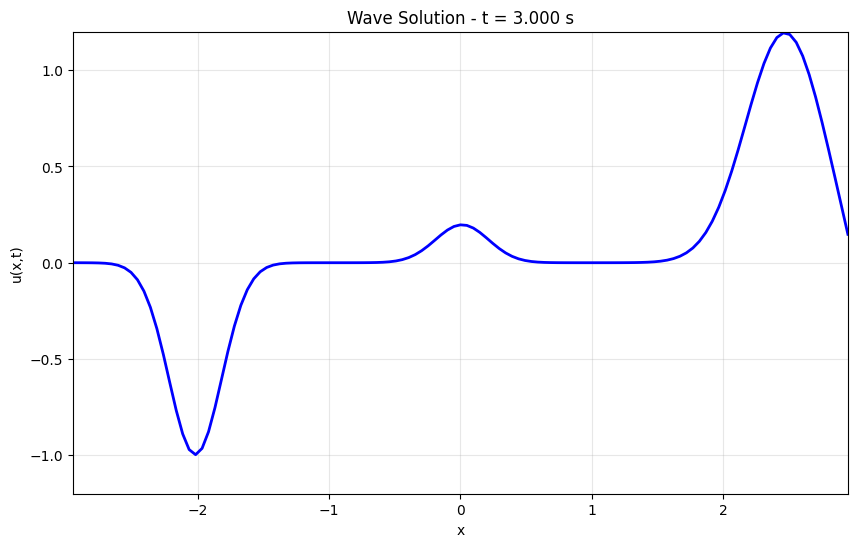

In [11]:
# Se %matplotlib widget não funcionar, use esta versão:
%matplotlib inline

# Importar bibliotecas necessárias
from IPython.display import HTML

nt = U.shape[0]

# Configuração da animação
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(x, U[0, :], '-', lw=2, color='blue')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')
ax.set_title('Wave Solution Animation')
ax.grid(True, alpha=0.3)

def update(frame):
    line.set_ydata(U[frame, :])
    ax.set_title(f'Wave Solution - t = {frame * dt * 20:.3f} s')
    return line,

# Criar animação
interval_frames = 2  # Pula alguns frames para performance
ani = animation.FuncAnimation(fig, update, frames=range(0, nt, interval_frames),
                              interval=100, blit=True, repeat=True)

# Mostrar como HTML (para Jupyter)
HTML(ani.to_jshtml())